## VQ-VAE

Vector Quantized Variational Autoencoder (VQ-VAE) is a generative model succesfully combining the variational
autoencoder (VAE) framework with discrete latent representations through a novel parameterisation
of the posterior distribution of (discrete) latents given an observation

### Reference
- https://keras.io/examples/generative/vq_vae/
- [Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937)
- https://github.com/deepmind/sonnet/blob/v2/examples/vqvae_example.ipynb

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class ExponentialMovingAverage(nn.Module):
    """Maintains an exponential moving average for a value.
    
      This module keeps track of a hidden exponential moving average that is
      initialized as a vector of zeros which is then normalized to give the average.
      This gives us a moving average which isn't biased towards either zero or the
      initial value. Reference (https://arxiv.org/pdf/1412.6980.pdf)
      
      Initially:
          hidden_0 = 0
      Then iteratively:
          hidden_i = hidden_{i-1} - (hidden_{i-1} - value) * (1 - decay)
          average_i = hidden_i / (1 - decay^i)
    """
    
    def __init__(self, init_value, decay):
        super().__init__()
        
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros_like(init_value))
        
    def forward(self, value):
        self.counter += 1
        self.hidden.sub_((self.hidden - value) * (1 - self.decay))
        average = self.hidden / (1 - self.decay ** self.counter)
        return average
        
    
class VectorQuantizerEMA(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. Use EMA to update embeddings.
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
        decay (float): decay for the moving averages.
        epsilon (float): small float constant to avoid numerical instability.
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost, decay,
               epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.epsilon = epsilon
        
        # initialize embeddings as buffers
        embeddings = torch.empty(self.num_embeddings, self.embedding_dim)
        nn.init.xavier_uniform_(embeddings)
        self.register_buffer("embeddings", embeddings)
        self.ema_dw = ExponentialMovingAverage(self.embeddings, decay)
        
        # also maintain ema_cluster_size， which record the size of each embedding
        self.ema_cluster_size = ExponentialMovingAverage(torch.zeros((self.num_embeddings,)), decay)
        
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 3, 1, 2).contiguous()
            return quantized
        
        # update embeddings with EMA
        with torch.no_grad():
            encodings = F.one_hot(encoding_indices, self.num_embeddings).float()
            updated_ema_cluster_size = self.ema_cluster_size(torch.sum(encodings, dim=0))
            n = torch.sum(updated_ema_cluster_size)
            updated_ema_cluster_size = ((updated_ema_cluster_size + self.epsilon) /
                                      (n + self.num_embeddings * self.epsilon) * n)
            dw = torch.matmul(encodings.t(), flat_x) # sum encoding vectors of each cluster
            updated_ema_dw = self.ema_dw(dw)
            normalised_updated_ema_w = (
              updated_ema_dw / updated_ema_cluster_size.reshape(-1, 1))
            self.embeddings.data = normalised_updated_ema_w
        
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        loss = self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings ** 2, dim=1) -
            2. * torch.matmul(flat_x, self.embeddings.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return F.embedding(encoding_indices, self.embeddings) 

In [3]:
class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        self._layers = nn.ModuleList()
        for i in range(num_residual_layers):
            self._layers.append(nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(num_hiddens, num_residual_hiddens, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(num_residual_hiddens, num_hiddens, 3, padding=1),
            ))
                    
    def forward(self, x):
        h = x
        for layer in self._layers:
            conv = layer(h)
            h = h + conv
        return F.relu(h)


class Encoder(nn.Module):
    def __init__(self, in_dim, embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        self._enc_1 = nn.Conv2d(in_dim, self._num_hiddens // 2, 4, stride=2, padding=1)
        self._enc_2 = nn.Conv2d(self._num_hiddens // 2, self._num_hiddens, 4, stride=2, padding=1)
        self._enc_3 = nn.Conv2d(self._num_hiddens, self._num_hiddens, 3, stride=1, padding=1)
        self._residual_stack = ResidualStack(self._num_hiddens, self._num_residual_layers,
                                             self._num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(self._num_hiddens, embedding_dim, 1)
        
    def forward(self, x):
        h = F.relu(self._enc_1(x))
        h = F.relu(self._enc_2(h))
        h = F.relu(self._enc_3(h))
        h = self._residual_stack(h)
        h = self.pre_vq_conv(h)
        return h


class Decoder(nn.Module):
    def __init__(self, out_dim, embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        self._num_hiddens = num_hiddens
        self._num_residual_layers = num_residual_layers
        self._num_residual_hiddens = num_residual_hiddens

        self._dec_1 = nn.Conv2d(embedding_dim, self._num_hiddens, 3, stride=1, padding=1)
        self._residual_stack = ResidualStack(self._num_hiddens, self._num_residual_layers, self._num_residual_hiddens)
        self._dec_2 = nn.ConvTranspose2d(self._num_hiddens, self._num_hiddens // 2, 4, stride=2, padding=1)
        self._dec_3 = nn.ConvTranspose2d(self._num_hiddens // 2, out_dim, 4, stride=2, padding=1)
        
    def forward(self, x):
        h = self._dec_1(x)
        h = self._residual_stack(h)
        h = F.relu(self._dec_2(h))
        recon = self._dec_3(h)
        return recon

In [4]:
class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, num_embeddings, data_variance, 
                 num_hiddens, num_residual_layers, num_residual_hiddens,
                 commitment_cost=0.25, decay=0.99):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = Encoder(in_dim, embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)
        self.vq_layer = VectorQuantizerEMA(embedding_dim, num_embeddings, commitment_cost, decay)
        self.decoder = Decoder(in_dim, embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon
        
        e, e_q_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return e_q_loss + recon_loss 

In [5]:
# Set hyper-parameters.
batch_size = 32
image_size = 32

epochs = 10

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

decay = 0.99

learning_rate = 3e-4

In [6]:
# dataset

transform=transforms.Compose([
    transforms.ToTensor(),
])


dataset1 = datasets.CIFAR10('/data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.CIFAR10('/data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

Files already downloaded and verified


In [7]:
# compute the variance of the whole training set to normalise the Mean Squared Error below.
train_images = []
for images, labels in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)
train_data_variance = torch.var(train_images)

In [8]:
model = VQVAE(3, embedding_dim, num_embeddings, train_data_variance, num_hiddens,
             num_residual_layers, num_residual_hiddens, commitment_cost, decay)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# train VQ-VAE
epochs = 20
print_freq = 1000

for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        loss = model(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [999/1563]: loss 0.14651767909526825
	 [1562/1563]: loss 0.09249838441610336
Start training epoch 1
	 [999/1563]: loss 0.11265300214290619
	 [1562/1563]: loss 0.11810425668954849
Start training epoch 2
	 [999/1563]: loss 0.10018464177846909
	 [1562/1563]: loss 0.10004650056362152
Start training epoch 3
	 [999/1563]: loss 0.09136302769184113
	 [1562/1563]: loss 0.08366110920906067
Start training epoch 4
	 [999/1563]: loss 0.09853560477495193
	 [1562/1563]: loss 0.108945831656456
Start training epoch 5
	 [999/1563]: loss 0.09308569133281708
	 [1562/1563]: loss 0.09637634456157684
Start training epoch 6
	 [999/1563]: loss 0.10045672953128815
	 [1562/1563]: loss 0.0750117376446724
Start training epoch 7
	 [999/1563]: loss 0.0916343480348587
	 [1562/1563]: loss 0.09816299378871918
Start training epoch 8
	 [999/1563]: loss 0.10320828855037689
	 [1562/1563]: loss 0.10410001128911972
Start training epoch 9
	 [999/1563]: loss 0.09285472333431244
	 [1562/1563]: loss 0.09

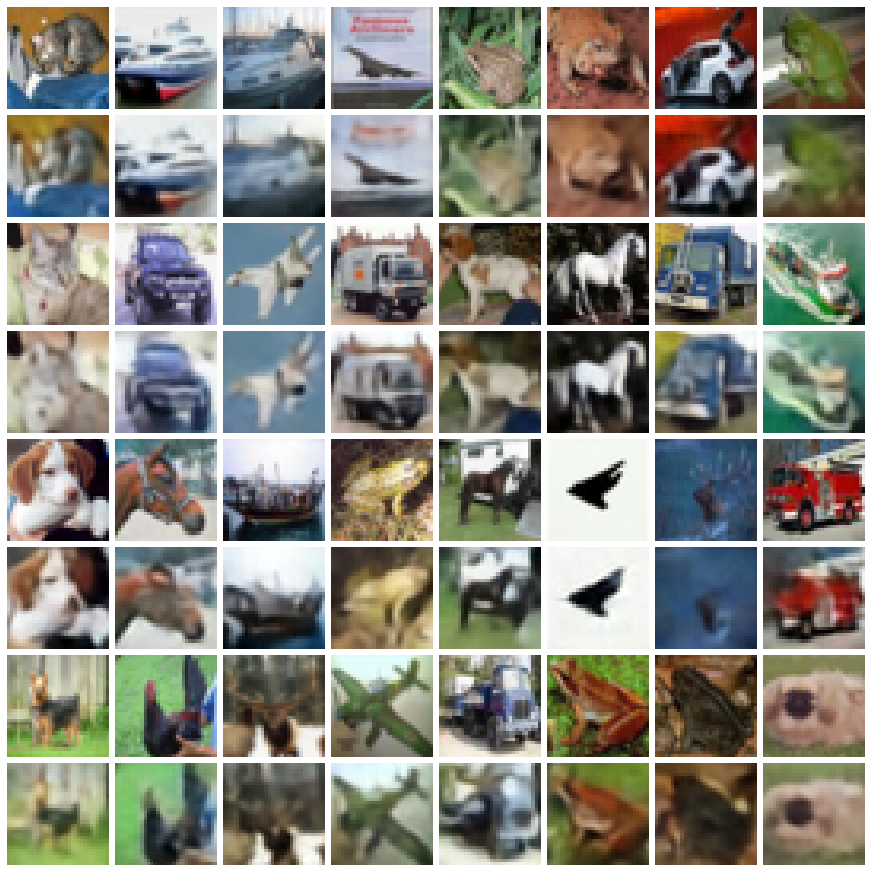

In [10]:
# reconstructe images

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 32
images = images[:n_samples]

model.eval()

norm_images = (images - 0.5).cuda()
with torch.inference_mode():
    e, recon_images = model(norm_images)

recon_images = np.array(np.clip((recon_images + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
ori_images = np.array(images.numpy() * 255, dtype=np.uint8)

recon_images = recon_images.reshape(4, 8, 3, image_size, image_size)
ori_images = ori_images.reshape(4, 8, 3, image_size, image_size)

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row * 2, n_col])
        f_ax.imshow(ori_images[n_row, n_col].transpose(1, 2, 0))
        f_ax.axis("off")
        f_ax = fig.add_subplot(gs[n_row * 2 + 1, n_col])
        f_ax.imshow(recon_images[n_row, n_col].transpose(1, 2, 0))
        f_ax.axis("off")